In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping

import wandb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 128 if AVAIL_GPUS else 32

In [2]:
pl.seed_everything(125)

Global seed set to 125


125

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## 1. Data Description

In [4]:
def gen_data(n, range_x=[-2, 2], scale_noise=0.2, sc=None):
    x = torch.linspace(range_x[0], range_x[1], n)
    y_true = x + torch.sin(x * 2 * torch.pi)
    y_noise = y_true + torch.randn((n,)) * scale_noise
    if sc is None:
        return x, y_noise, y_true
    else:
        y_true = sc.transform(y_true.reshape(-1, 1))
        y_noise = sc.transform(y_noise.reshape(-1, 1))
        y_true = torch.tensor(y_true, dtype=torch.float)
        y_noise = torch.tensor(y_noise, dtype=torch.float)
        return x, y_noise, y_true

arr_x, arr_y_noise, arr_y = gen_data(1500)

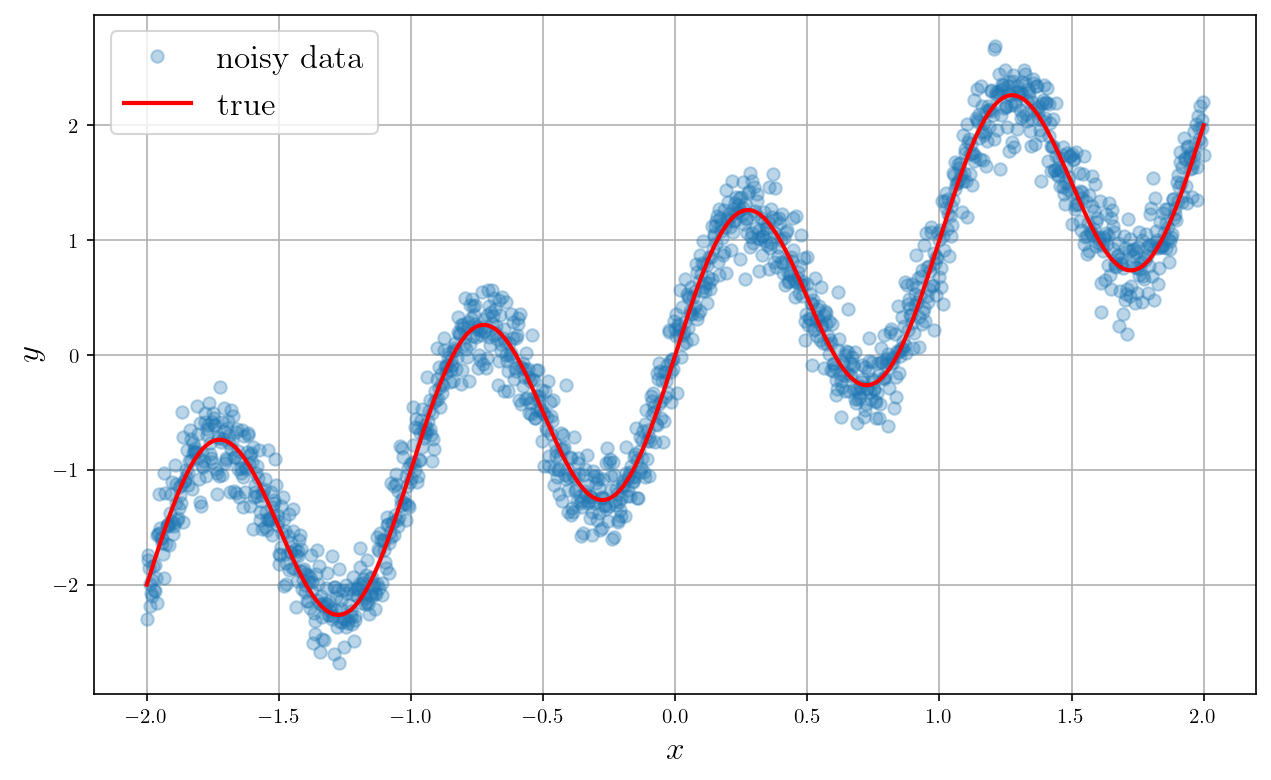

In [5]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(arr_x, arr_y_noise, 'o', label='noisy data', alpha=0.3)
plt.plot(arr_x, arr_y, 'r-', linewidth=2,label='true')
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

In [6]:
sc = MinMaxScaler()
sc.fit(arr_y.reshape(-1,1))
y_noise_norm = torch.tensor(sc.transform(arr_y_noise.reshape(-1,1)))
y_norm = torch.tensor(sc.transform(arr_y.reshape(-1,1)))
y_normalized = torch.column_stack([y_noise_norm, y_norm])

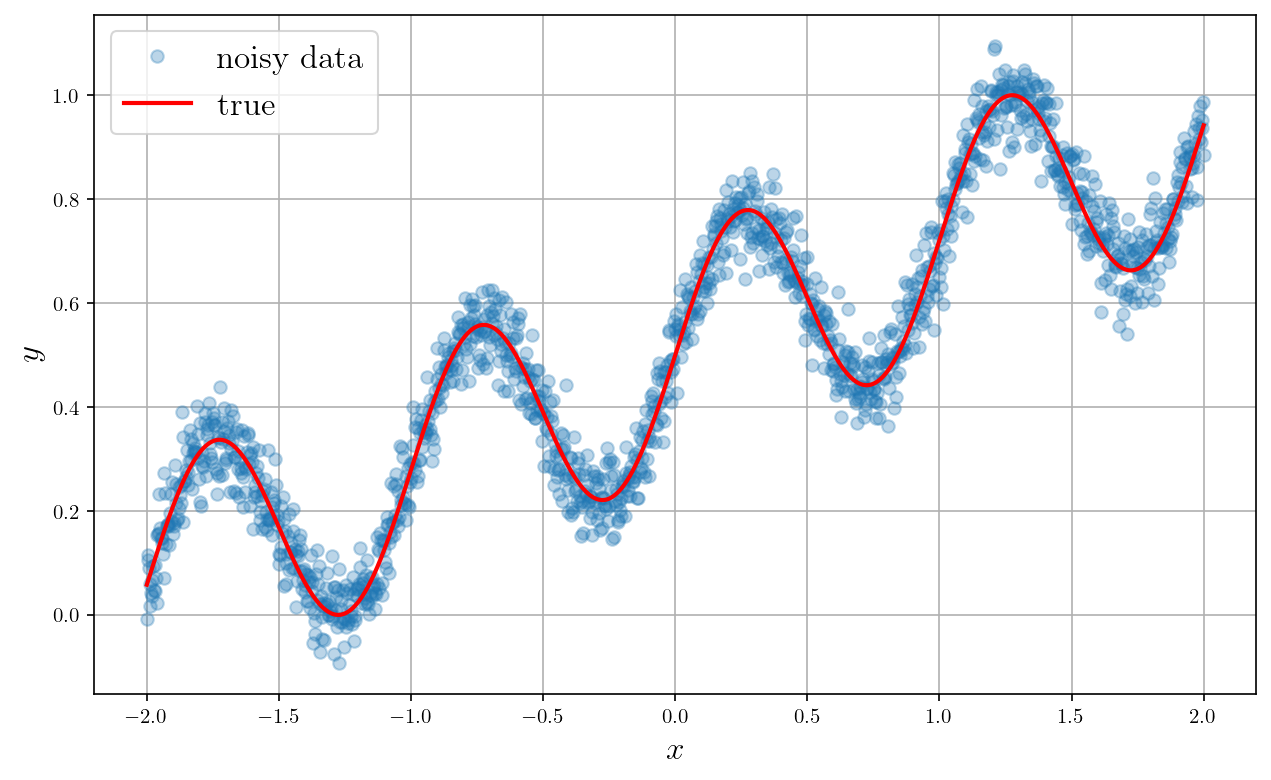

In [7]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(arr_x, y_normalized[:,0], 'o', label='noisy data', alpha=0.3)
plt.plot(arr_x, y_normalized[:,1], 'r-', linewidth=2,label='true')
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

## 2. Make Dataset

In [8]:
class NoisyData(Dataset):
    def __init__(self, x, y, y_true):
        self.x = x.reshape((-1,1))
        self.y = y.reshape((-1,1))
        self.y_true = y_true.reshape((-1,1))
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.y_true[idx]

In [9]:
def gen_noisy_data(n, range_x=[-2,4], sc=None):
    return NoisyData(*gen_data(n, range_x=range_x, sc=sc))

## 3. MLP 1

### 3.1. Define Model

In [10]:
class NoisyNet(pl.LightningModule):
    def __init__(self, N=10000, hparams=None):
        super().__init__()
        
        self.N = N
        
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )
        
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.epochs = hparams['epochs']
        
        self.save_hyperparameters(hparams)
    
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y, y_hat)
        
        self.log('train_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y, y_hat)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self):
        self.ds = NoisyData(*gen_data(self.N, range_x=[-2, 2], sc=sc))
        self.ds2 = NoisyData(*gen_data(self.N // 5, range_x=[-2, 2], sc=sc))
        
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds2, [N_train, N_val])
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [11]:
# hparams = {
#     "learning_rate": 1e-3,
#     "batch_size": BATCH_SIZE,
#     "epochs": 10000
# }

# model = NoisyNet(
#     hparams=hparams
# )

# wandb_logger = WandbLogger(
#     project='MLP2Autoregressive'
# )

# trainer = Trainer(
#     logger=wandb_logger,
#     max_epochs=hparams['epochs'],
#     gpus=AVAIL_GPUS,
#     enable_progress_bar=False,
#     callbacks=[
#         EarlyStopping(monitor='val_loss', patience=50, mode='min')
#     ]
    
# )

### 3.2. Train

In [12]:
#trainer.fit(model)

In [13]:
#wandb.finish()

In [14]:
best_path = "/home/xteca/Documents/Project/Machine_Learning/MLTest/MLP2Autoregressive/xzaifq1z/checkpoints/epoch=103-step=5720.ckpt"
best_model = NoisyNet.load_from_checkpoint(best_path)
best_model.eval()

NoisyNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

### 3.3. Test

In [15]:
test_data = gen_noisy_data(1000, range_x=[-2,2], sc=sc)
x = test_data.x
y = test_data.y
y_true = test_data.y_true
y_hat = best_model(x).detach().cpu().numpy()

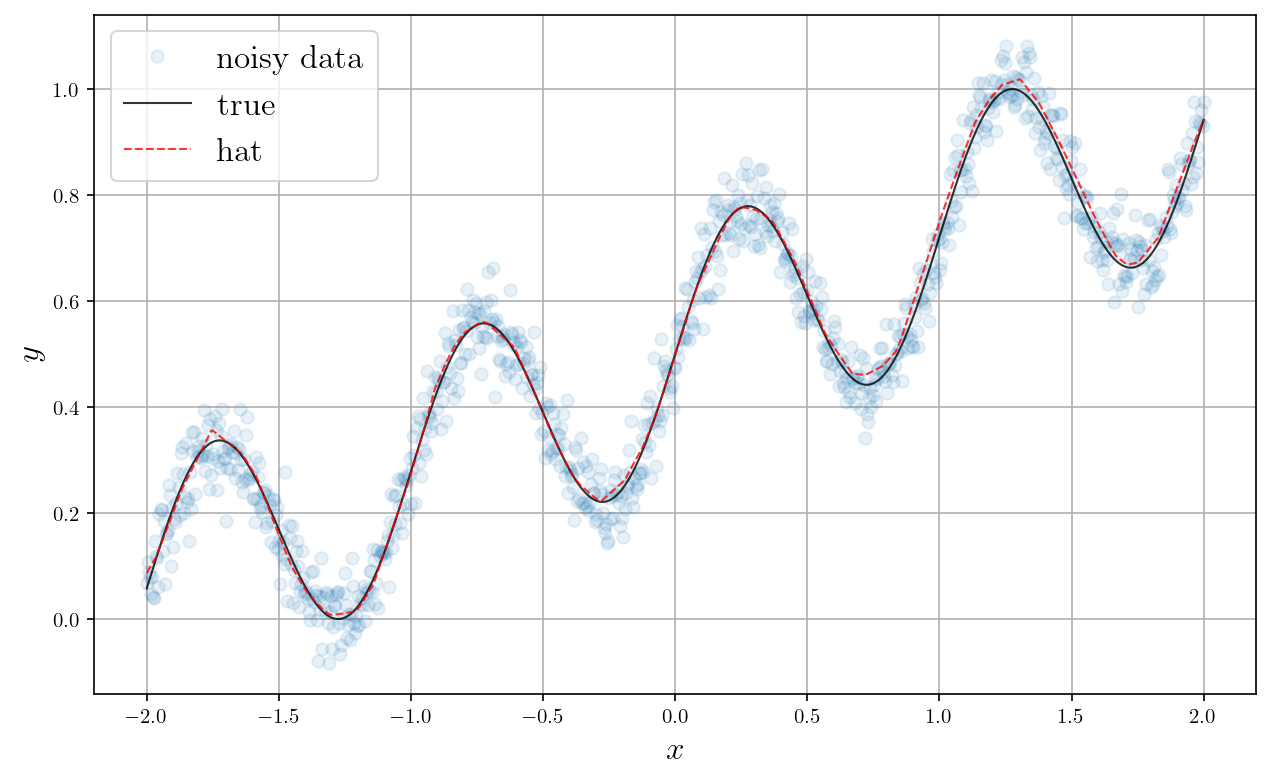

In [16]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, y, 'o', label='noisy data', alpha=0.1)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'r--', linewidth=1, label='hat', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

In [17]:
inv = sc.inverse_transform

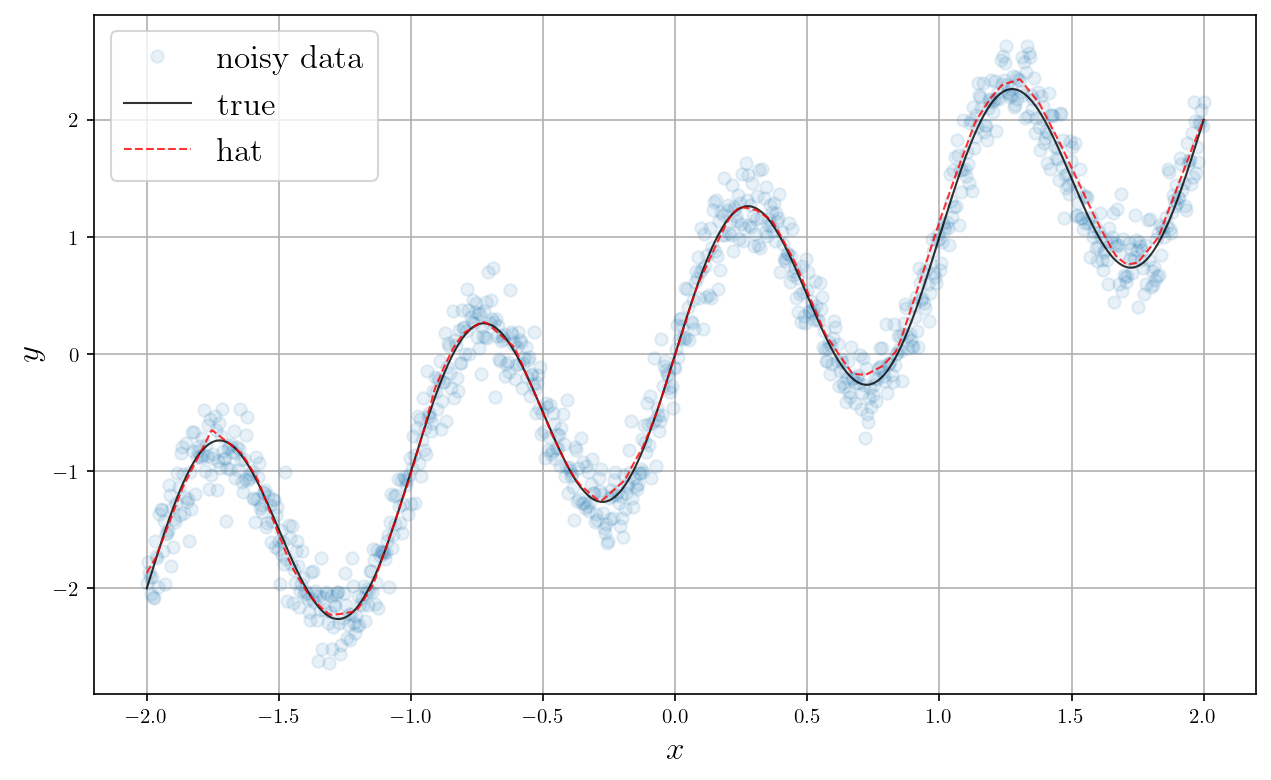

In [18]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, inv(y), 'o', label='noisy data', alpha=0.1)
plt.plot(x, inv(y_true), 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, inv(y_hat), 'r--', linewidth=1, label='hat', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

## 4. Auto regressive Data

In [19]:
def sliding_window(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length - 20):
        _x = data[i:i+seq_length].tolist()
        _y = data[i+seq_length:i+seq_length+20].tolist()
        x.append(_x)
        y.append(_y)
    return torch.tensor(x), torch.tensor(y)

In [20]:
class AutoRegData(Dataset):
    def __init__(self, y):
        x_, y_ = sliding_window(y, 100)
        self.x = x_
        self.y = y_
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [21]:
class AutoRegVal(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [22]:
def restore_from_noisy(x, model):
    y_restore = model(x)
    return y_restore

In [23]:
ds_noisy = gen_noisy_data(1500, range_x=[-2,4], sc=sc)
ds_autoreg = AutoRegData(restore_from_noisy(ds_noisy.x, best_model))

In [24]:
x = ds_autoreg.x
y = ds_autoreg.y

In [25]:
x.shape

torch.Size([1380, 100, 1])

In [26]:
y.shape

torch.Size([1380, 20, 1])

In [27]:
ds = gen_noisy_data(1000, range_x=[-2,2], sc=sc)

x_val = ds.x[-120:].reshape((-1, 120, 1))
y_val = best_model(x_val)

ds_val = AutoRegVal(
    y_val[:,:100], y_val[:,100:]
)

In [28]:
ds_val.x.shape

torch.Size([1, 100, 1])

## 5. LSTM

In [29]:
class AutoRegNet(pl.LightningModule):
    def __init__(self, N=1000, hparams=None):
        super().__init__()
        
        self.N = N
        
        self.rnn = nn.LSTM(1, 30, 2, batch_first=True)
        self.fc = nn.Linear(30, 20)
        
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.epochs = hparams['epochs']
        
        self.save_hyperparameters(hparams)
    
    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        output = self.fc(rnn_output)
        return output[:,-1].view((-1, 20, 1))
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = F.mse_loss(y_hat, y)
        
        self.log('train_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = F.mse_loss(y_hat, y)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self):
        ds = gen_noisy_data(self.N, range_x=[-2,2], sc=sc)
        self.ds_train = AutoRegData(restore_from_noisy(ds.x, best_model))
        x_val = ds.x[-120:].reshape((-1,120,1))
        y_val = best_model(x_val)

        self.ds_val = AutoRegVal(
            y_val[:,:100], y_val[:,100:]
        )
        
    def setup(self, stage=None):
        pass
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=1)

In [30]:
hparams = {
    "learning_rate": 1e-4,
    "batch_size": 10,
    "epochs": 1000
}

model2 = AutoRegNet(
    hparams=hparams
)

wandb_logger = WandbLogger(
    project='MLP2Autoregressive'
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=50,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=hparams['epochs'],
    gpus=AVAIL_GPUS,
    enable_progress_bar=False,
#     callbacks=[
#         early_stop_callback
#     ]
)

wandb: Currently logged in as: axect (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
model2(ds_autoreg.x).shape

torch.Size([1380, 20, 1])

In [32]:
trainer.fit(model2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | rnn  | LSTM   | 11.4 K
1 | fc   | Linear | 620   
--------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)
/home/xteca/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/xteca/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try

In [33]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,999
train_loss,0.00016
trainer/global_step,87999
val_loss,0.0002


In [34]:
best_path2 = trainer.checkpoint_callback.best_model_path
print(best_path2)
best_model2 = AutoRegNet.load_from_checkpoint(best_path2)
best_model2.eval()

/home/xteca/Documents/Project/Machine_Learning/MLTest/MLP2Autoregressive/pzugfp0u/checkpoints/epoch=999-step=88000.ckpt


AutoRegNet(
  (rnn): LSTM(1, 30, num_layers=2, batch_first=True)
  (fc): Linear(in_features=30, out_features=20, bias=True)
)

## 6. Test

### 6.1. Extrapolation of First MLP

In [35]:
ds_noisy = gen_noisy_data(1500, range_x=[-2,4], sc=sc)

In [36]:
x = ds_noisy.x
y = ds_noisy.y
y_true = ds_noisy.y_true
y_hat = best_model(x).detach().cpu().numpy()

In [37]:
ics = x <= 2
x_in = x[ics].reshape((-1,1))
y_in = y[ics].reshape((-1,1))
y_true_in = y_true[ics].reshape((-1,1))
y_hat_in = y_hat[ics]

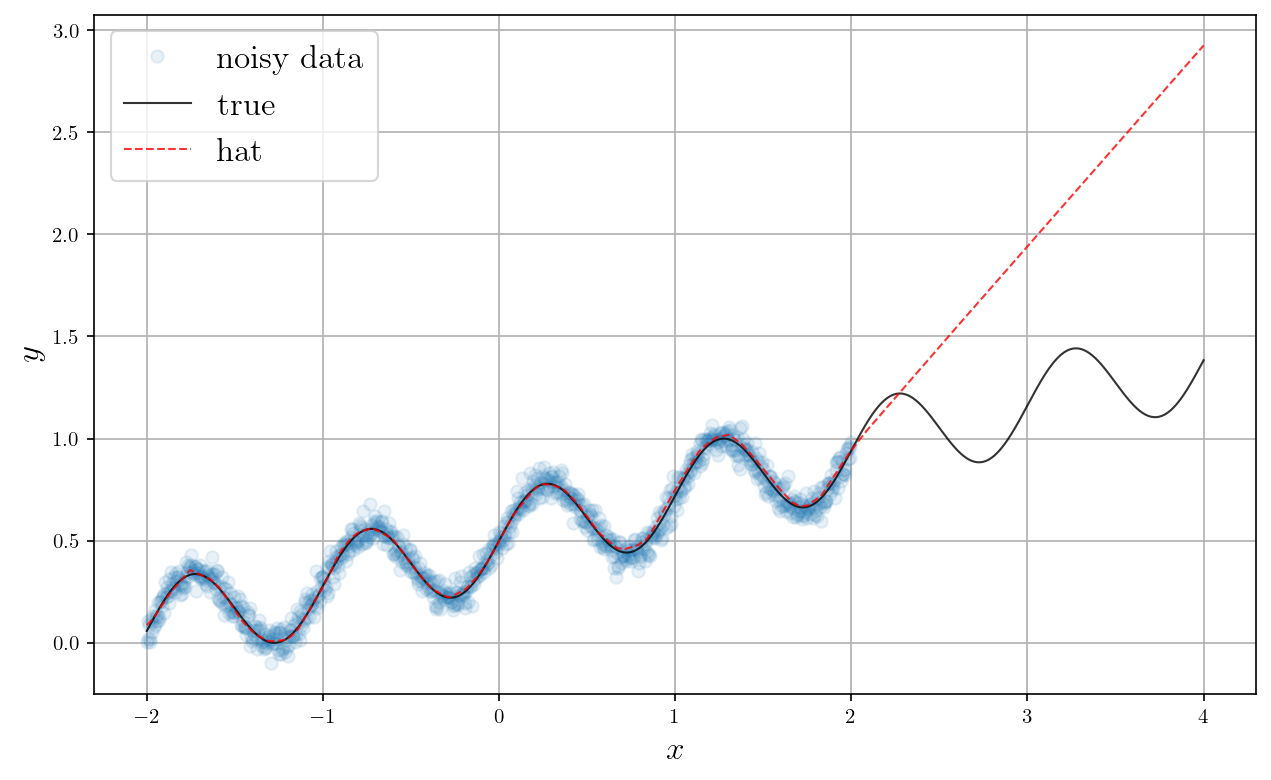

In [38]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x_in, y_in, 'o', label='noisy data', alpha=0.1)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'r--', linewidth=1, label='hat', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

### 6.2. Interpolation of RNN

In [39]:
ds_autoreg = AutoRegData(restore_from_noisy(x_in, best_model))

In [40]:
X_in = ds_autoreg.x
X_in.shape

torch.Size([880, 100, 1])

In [41]:
y_pred_in = best_model2(X_in).detach().cpu().numpy()
y_pred_in.shape

(880, 20, 1)

In [42]:
x_plot = x_in[100:-20].reshape((-1,))
x_plot.shape

torch.Size([880])

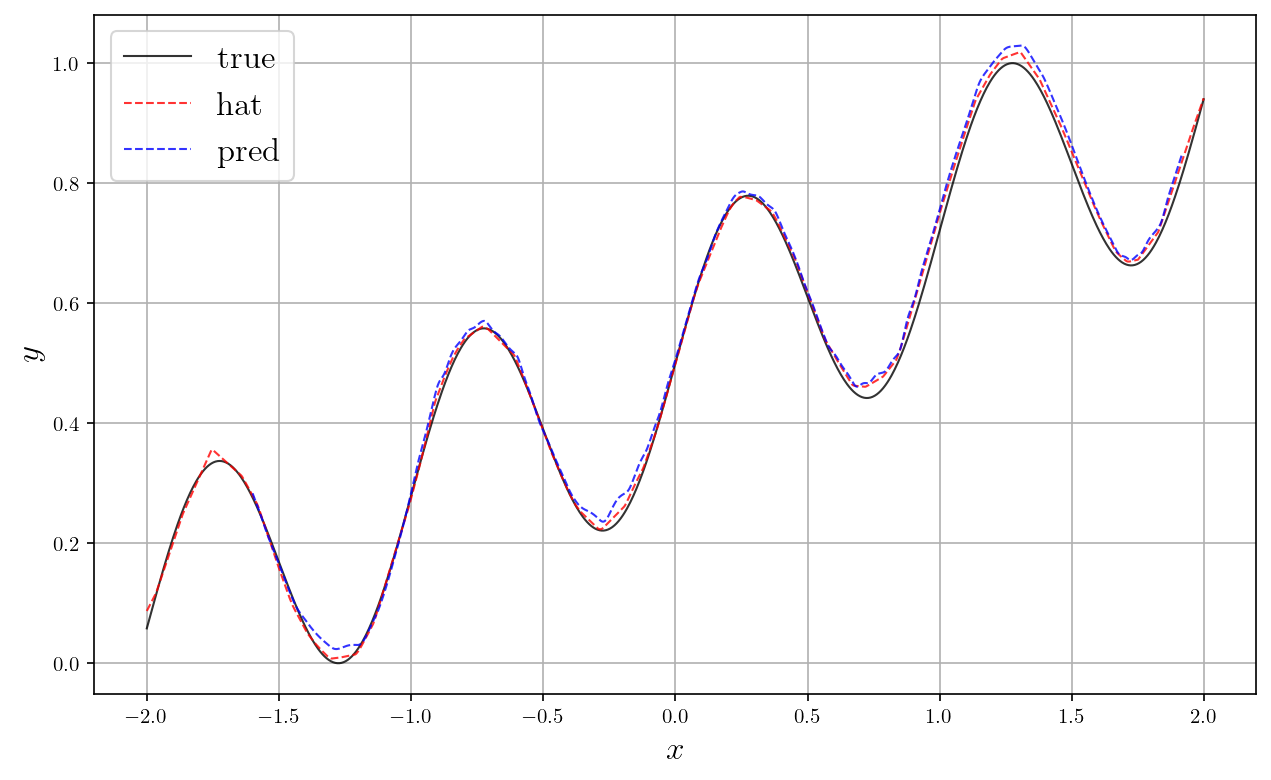

In [43]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x_in, y_true_in, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x_in, y_hat_in, 'r--', linewidth=1, label='hat', alpha=0.8)
plt.plot(x_plot, y_pred_in[:,0,:], 'b--', linewidth=1, label='pred', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

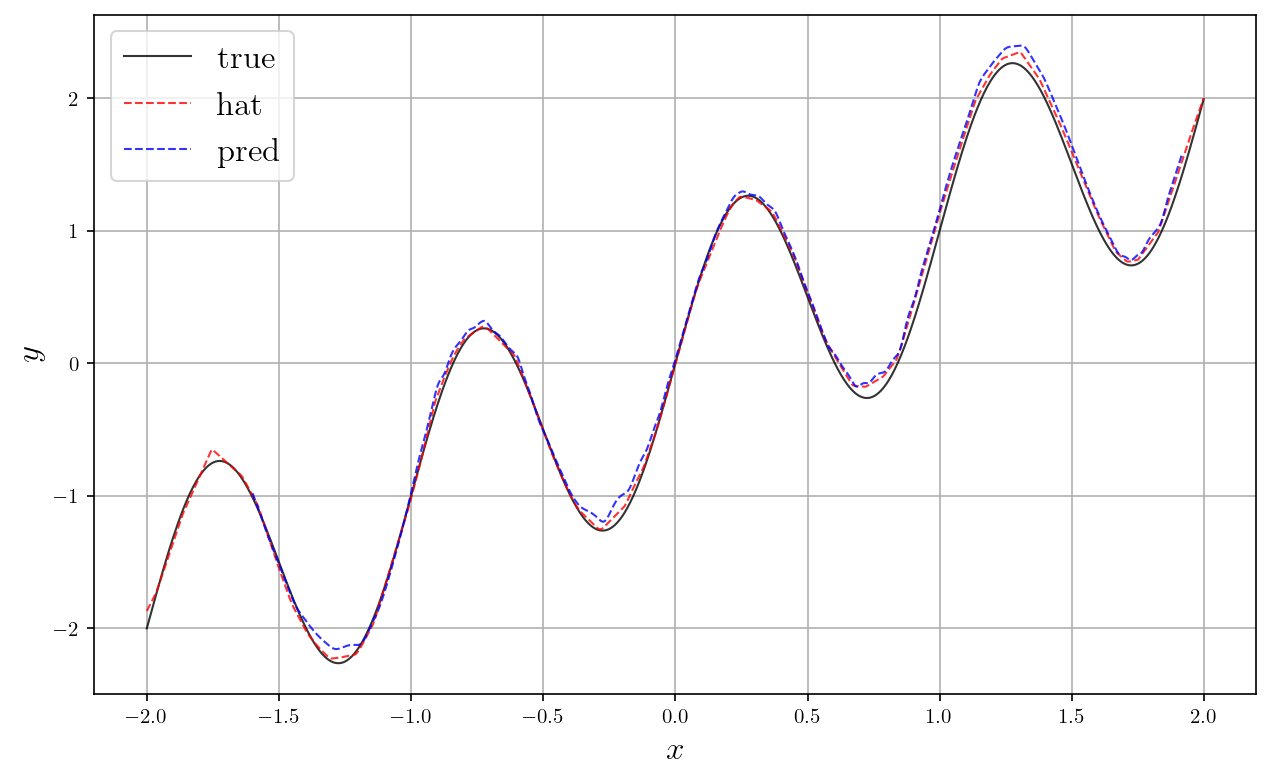

In [44]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x_in, inv(y_true_in), 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x_in, inv(y_hat_in.reshape(-1,1)), 'r--', linewidth=1, label='hat', alpha=0.8)
plt.plot(x_plot, inv(y_pred_in[:,0].reshape(-1,1)), 'b--', linewidth=1, label='pred', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

### 6.3. Extrapolation

In [45]:
sc2 = MinMaxScaler()
ds_temp = gen_noisy_data(500, range_x=[1.5,4])
sc2.fit(ds_temp.y_true)

MinMaxScaler()

In [46]:
# X_ex = torch.tensor(X_in[-1], dtype=torch.float)
# x_ex = x[~ics]
# y_ex = []
# out_old = None
# for i in range(500):
#     out = best_model2(X_ex.view(1,-1,1))
#     X_ex = torch.concat([X_ex[1:], out[0,0:1]])
#     y_ex.extend(out[0,:,0].view(-1).detach().numpy())
#     out_old = out
# y_ex = np.array(y_ex)

In [53]:
X_ex = torch.tensor(X_in[-1], dtype=torch.float)
x_ex = torch.concat([x_in[-20:].reshape(-1), x[~ics]])
# x_ex = x_in[-20:].reshape(-1)
y_ex = []
out_old = None
for i in range(26):
    out = best_model2(X_ex.view(1,-1,1))
    X_ex = torch.concat([X_ex[20:], out[0,:,:]])
    y_ex.extend(out[0,:,:].view(-1).detach().numpy())
    out_old = out
y_ex = np.array(y_ex)

/tmp/ipykernel_18053/1992070738.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_ex = torch.tensor(X_in[-1], dtype=torch.float)


In [54]:
inv2 = sc2.inverse_transform

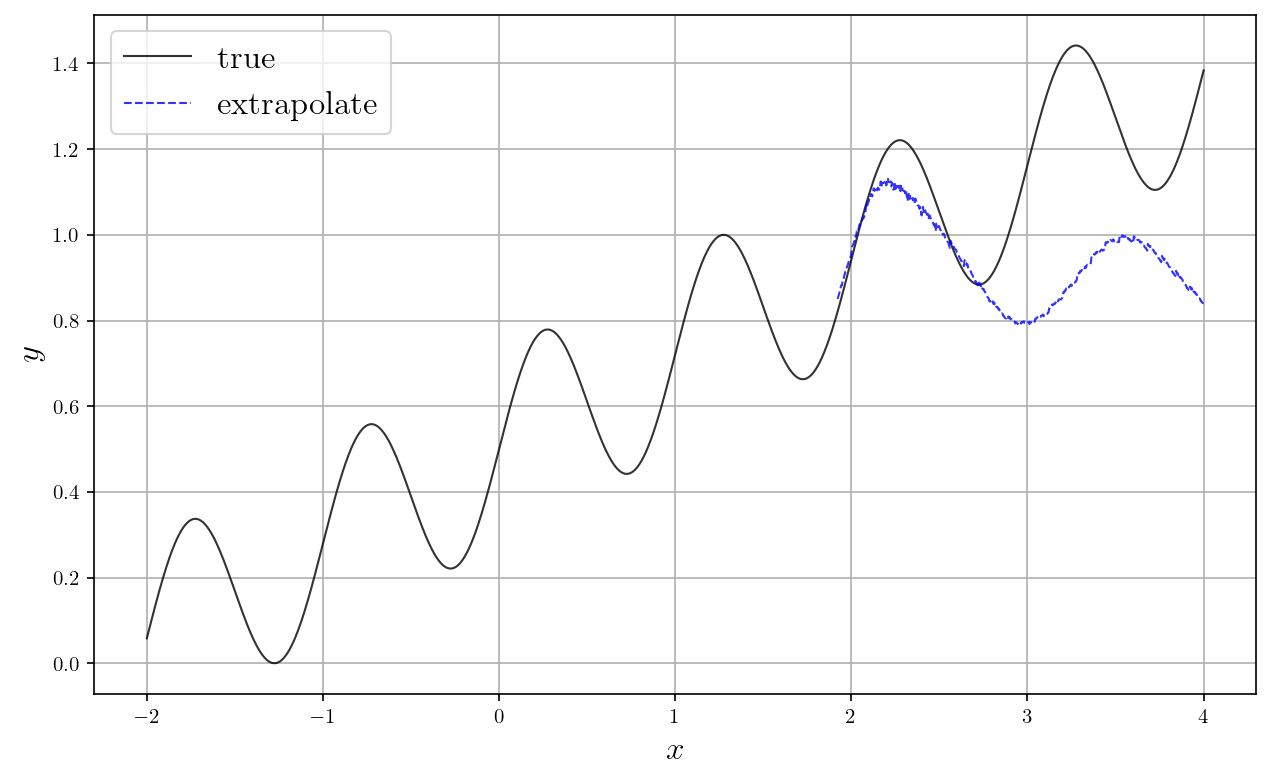

In [58]:
plt.figure(figsize=(10, 6), dpi=150)
# plt.plot(x_in, y_in, 'o', label='noisy data', alpha=0.1)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
# plt.plot(x_in, y_true_in, 'k-', linewidth=1, label='true', alpha=0.8)
# plt.plot(x, y_hat, 'r--', linewidth=1, label='hat', alpha=0.8)
# plt.plot(x_plot, y_pred_in[:,0], 'g-', linewidth=1, label='pred', alpha=0.8)
plt.plot(x_ex, y_ex, 'b--', linewidth=1, label='extrapolate', alpha=0.8)
# plt.plot(x_ex, y_true_in[-20:])
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
# plt.xlim([1.5, 2.0])
# plt.ylim([0.6, 1.0])
plt.show()

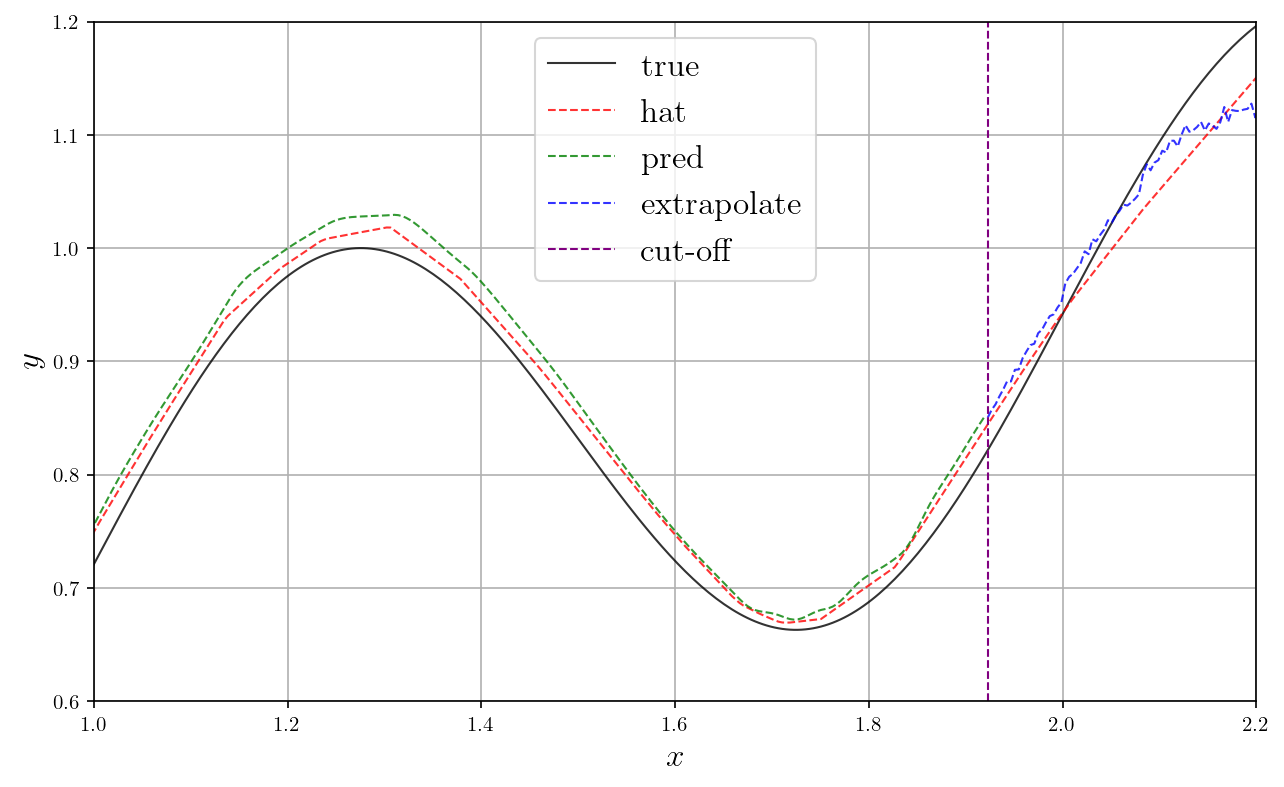

In [77]:
plt.figure(figsize=(10, 6), dpi=150)
# plt.plot(x_in, y_in, 'o', label='noisy data', alpha=0.1)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
# plt.plot(x_in, y_true_in, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'r--', linewidth=1, label='hat', alpha=0.8)
plt.plot(x_plot, y_pred_in[:,0], 'g--', linewidth=1, label='pred', alpha=0.8)
plt.plot(x_ex, y_ex, 'b--', linewidth=1, label='extrapolate', alpha=0.8)
plt.axvline(x_ex[0], color='purple', linewidth=1, linestyle='dashed', label='cut-off')
# plt.plot(x_ex, y_true_in[-20:])
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)

plt.xlim([1.0, 2.2])
plt.ylim([0.6, 1.2])

# plt.savefig("rnn_extrapolate.png")
plt.show()